# Neural Networks 101 with `gluon`

Now we're going to implement a simple example of training a neural network with Gluon. We'll walk through all of the steps that you'll typically need, regardless of the application. Namely:

1. Define network
1. Initialize parameters
1. Loop over inputs
  1. Propagate forward to compute the output and loss
  1. Propagate backward to calculate the gradient
  1. Update parameters by stochastic gradient descent
1. Save parameters  

In [1]:
from __future__ import print_function
import mxnet as mx
import mlp_utils
import d2l
from mxnet import nd, autograd, gluon
import warnings
warnings.filterwarnings('ignore')

## Fashion-MNIST Data

In [2]:
mnist_train = gluon.data.vision.FashionMNIST(train=True)
mnist_test = gluon.data.vision.FashionMNIST(train=False)
len(mnist_train), len(mnist_test)

(60000, 10000)

We can access any example by square brackets `[]`, and next, we will get the image and label of the first example.

In [3]:
feature, label = mnist_train[0]
print(feature.shape, feature.dtype)
print(label, type(label), label.dtype)

(28, 28, 1) <class 'numpy.uint8'>
2 <class 'numpy.int32'> int32


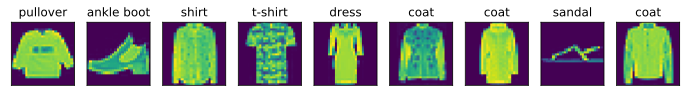

In [4]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

X, y = mnist_train[0:9]
mlp_utils.show_fashion_mnist(X, get_fashion_mnist_labels(y))

## Model Definition

### `Block`s in `gluon`

`gluon.Block` is the basic building block of models. You can define networks by
composing and inheriting `Block`.

Any object that inherits from `gluon.Block` and defines a `forward` function is a `Block`.

```
class Net(gluon.Block):
    # One or more NDArrays can be passed
    def forward(self, x):
        # Computate y based on data x
        return y
```

### Purpose of `Block`

- *Computation* (usually) depends on input data as well as parameters to be learned
- Inconvenient to manually pass parameters and data to function, so `gluon.Block` encapsulates parameters

### Using `Block`s

- Gluon defines many `Block`s for you
- For example `Dense` layers
- `Dense` implements `output = activation(dot(input, weight) + bias)`


### A Stack of `Block`s

In [5]:
net = gluon.nn.Sequential()
net.add(gluon.nn.Dense(256, in_units=784, activation='relu'))
net.add(gluon.nn.Dense(10, in_units=256))

As promised, the `Dense` layer encapsulates the parameters for us:

In [6]:
# use [0] to access the first layer
print(net[0].weight)
print(net[0].bias)

Parameter dense0_weight (shape=(256, 784), dtype=float32)
Parameter dense0_bias (shape=(256,), dtype=float32)


Here we relied on the knowledge that `Dense` exposes the parameters `weight` and `bias`.
But `Block`s can be composed and may contain more parameters.
`collect_params()` allows us to retrieve all Parameters associated with a `Block`.
    

In [7]:
net.collect_params()

sequential0_ (
  Parameter dense0_weight (shape=(256, 784), dtype=float32)
  Parameter dense0_bias (shape=(256,), dtype=float32)
  Parameter dense1_weight (shape=(10, 256), dtype=float32)
  Parameter dense1_bias (shape=(10,), dtype=float32)
)

Before we can use the `Block`, we need to tell ``gluon`` what the *initial values* for our parameters should be!

We'll need to pass in two arguments. 

* An initializer, many of which live in the `mx.init` module. 
* A context where the parameters should live. In this case we'll pass in the `model_ctx`. Most often this will either be a GPU or a list of GPUs. 

In [8]:
# use mx.gpu(0) if a GPU is available
model_ctx = mx.cpu()
net.initialize(mx.initializer.Uniform(0.01), ctx=model_ctx)

Now we can access the actual parameter value:

In [9]:
print(net[0].weight.data())


[[ 9.7627006e-04  1.8568924e-03  4.3037869e-03 ... -4.3318528e-03
  -2.6811888e-03  7.6381695e-03]
 [ 9.3405955e-03  8.0124289e-03  9.4464514e-04 ... -2.0298846e-03
   4.3448443e-03  6.8325922e-03]
 [ 7.4685887e-03 -9.7777108e-03  9.3708131e-03 ... -7.8557758e-03
   1.3657939e-03 -5.8142021e-03]
 ...
 [-9.4654122e-03 -8.7947082e-03  5.8559254e-03 ...  3.8193325e-03
  -2.5428832e-05  2.0984830e-03]
 [ 6.7727212e-03  2.4509374e-03  4.1437931e-03 ...  5.5758758e-03
   9.7244848e-03  4.6974206e-03]
 [ 5.1790606e-03  1.4569340e-03 -6.6653737e-03 ... -5.0505535e-03
  -1.5457347e-03 -9.8876497e-03]]
<NDArray 256x784 @cpu(0)>


### Loss and Optimization

In [10]:
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

In [11]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.5})

### Data Iterator

In [12]:
batch_size = 256
transformer = gluon.data.vision.transforms.ToTensor()

train_iter = gluon.data.DataLoader(mnist_train.transform_first(transformer),
                                   batch_size, shuffle=True)
test_iter = gluon.data.DataLoader(mnist_test.transform_first(transformer),
                                  batch_size, shuffle=False)

### Training loop

In [13]:
def train_loop(epochs):
    for e in range(epochs):
        cumulative_loss = 0
        num_examples = 0
        for i, (data, label) in enumerate(train_iter):
            num_examples += data.shape[0]
            data = data.as_in_context(model_ctx)
            label = label.as_in_context(model_ctx)
            with autograd.record():
                output = net(data)
                loss = loss_fn(output, label)
            loss.backward()
            trainer.step(batch_size)
            cumulative_loss += nd.mean(loss).asscalar()
        print("Epoch %s, loss: %.4f" % (e, cumulative_loss / num_examples))

In [14]:
epochs = 3
train_loop(epochs)

Epoch 0, loss: 0.0032
Epoch 1, loss: 0.0019
Epoch 2, loss: 0.0017


## Evaluation

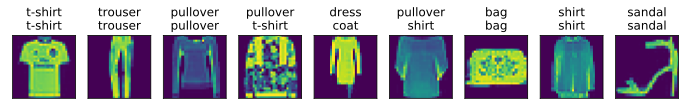

In [15]:
for X, y in test_iter:
    break

true_labels = d2l.get_fashion_mnist_labels(y.asnumpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1).asnumpy())
titles = [truelabel + '\n' + predlabel for truelabel, predlabel in zip(true_labels, pred_labels)]

d2l.show_fashion_mnist(X[0:9], titles[0:9])

## Loading and Saving Model

In [16]:
net.save_parameters('net.params')
net.load_parameters('net.params', ctx=model_ctx)